In [11]:
import re
import logging
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, mean_squared_error
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec
from gensim.utils import RULE_DEFAULT, RULE_KEEP
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import KeyedVectors

from utils_word import * 
from utils_ml import * 

In [12]:
ngram_abstracts = np.load("saved_files/ngram_abstracts.npy", mmap_mode="r")
filtered_concept_arr = np.unique(np.load("saved_files/overlapping_filtered_5_concepts.npy"))
year_arr = np.load("saved_files/year_arr.npy", mmap_mode="r")

In [13]:
word_co_occurrences = get_word_co_occurrences(filtered_concept_arr, ngram_abstracts, year_arr)

100%|██████████| 63633/63633 [00:03<00:00, 16847.57it/s]


In [14]:
load = True  
phys_concept_dict = {k: 1 for k in filtered_concept_arr}

year_train = 2017 #train_label_years => [2018, 2019, 2020]
year_test = 2020 # test_label_years => [2021, 2022, 2023]
if not load:
    df_ab = pd.DataFrame(data=ngram_abstracts,    # values
                columns=["ab"])  # 1st row as the column names
    df_ab["year"] = year_arr

    # Custom rule function
    def custom_rule(word, count, min_count):
        if word in phys_concept_dict:
            return RULE_KEEP
        else:
            return RULE_DEFAULT

    cores = multiprocessing.cpu_count()

    class LossLogger(CallbackAny2Vec):
        '''Callback to log loss after each epoch.'''
        def __init__(self):
            self.epoch = 0
            self.losses = []
            self.previous_loss = 0
            self.initial_loss = 0

        def on_epoch_begin(self, model):
            # Record the initial loss at the start of each epoch
            self.initial_loss = model.get_latest_training_loss()

        def on_epoch_end(self, model):
            current_loss = model.get_latest_training_loss()
            # Calculate the loss for the current epoch
            loss = current_loss - self.initial_loss
            self.losses.append(loss)
            self.initial_loss = current_loss  # Reset for the next epoch
            self.epoch += 1

    ngram_abstracts_year = [ab.split() for ab in df_ab[df_ab['year'] <= year_train]["ab"].to_numpy()]
    loss_logger = LossLogger()
    w2v_model = Word2Vec(min_count=5,
                        window=15,
                        vector_size=128,
                        sample=1e-4, 
                        alpha=0.01, 
                        min_alpha= 0.0001, 
                        negative=15,
                        workers=cores-1)
    # Build the vocabulary on the first year's data
    w2v_model.build_vocab(ngram_abstracts_year, trim_rule=custom_rule)
    w2v_model.train(ngram_abstracts_year, total_examples=w2v_model.corpus_count, epochs=50, compute_loss=True, callbacks=[loss_logger])
    w2v_model.save(f"saved_w2v_models/baseline_train_model_{year_train}.model")

    ngram_abstracts_year = [ab.split() for ab in df_ab[df_ab['year'] <= year_test]["ab"].to_numpy()]
    loss_logger = LossLogger()
    w2v_model = Word2Vec(min_count=5,
                        window=15,
                        vector_size=128,
                        sample=1e-4, 
                        alpha=0.01, 
                        min_alpha= 0.0001, 
                        negative=15,
                        workers=cores-1)
    # Build the vocabulary on the first year's data
    w2v_model.build_vocab(ngram_abstracts_year, trim_rule=custom_rule)
    w2v_model.train(ngram_abstracts_year, total_examples=w2v_model.corpus_count, epochs=50, compute_loss=True, callbacks=[loss_logger])
    w2v_model.save(f"saved_w2v_models/baseline_test_model_{year_test}.model")

In [15]:
baseline_1_train_encoding_arr, baseline_1_train_c_arr = get_baseline_1_embeddings(Word2Vec.load(f"saved_w2v_models/baseline_train_model_{year_train}.model"),filtered_concept_arr)

baseline_1_test_encoding_arr, baseline_1_test_c_arr = get_baseline_1_embeddings(Word2Vec.load(f"saved_w2v_models/baseline_test_model_{year_test}.model"),filtered_concept_arr)


2024-08-06 10:31:36,527 - INFO - loading Word2Vec object from saved_w2v_models/baseline_train_model_2017.model
2024-08-06 10:31:36,548 - INFO - loading wv recursively from saved_w2v_models/baseline_train_model_2017.model.wv.* with mmap=None
2024-08-06 10:31:36,549 - INFO - setting ignored attribute cum_table to None
2024-08-06 10:31:36,687 - INFO - Word2Vec lifecycle event {'fname': 'saved_w2v_models/baseline_train_model_2017.model', 'datetime': '2024-08-06T10:31:36.687608', 'gensim': '4.3.2', 'python': '3.9.13 (main, Aug 25 2022, 23:26:10) \n[GCC 11.2.0]', 'platform': 'Linux-6.5.0-45-generic-x86_64-with-glibc2.35', 'event': 'loaded'}
2024-08-06 10:31:36,727 - INFO - loading Word2Vec object from saved_w2v_models/baseline_test_model_2020.model
2024-08-06 10:31:36,756 - INFO - loading wv recursively from saved_w2v_models/baseline_test_model_2020.model.wv.* with mmap=None
2024-08-06 10:31:36,757 - INFO - setting ignored attribute cum_table to None


Found 9934 vectors, missed 301 vectors.


2024-08-06 10:31:36,920 - INFO - Word2Vec lifecycle event {'fname': 'saved_w2v_models/baseline_test_model_2020.model', 'datetime': '2024-08-06T10:31:36.920109', 'gensim': '4.3.2', 'python': '3.9.13 (main, Aug 25 2022, 23:26:10) \n[GCC 11.2.0]', 'platform': 'Linux-6.5.0-45-generic-x86_64-with-glibc2.35', 'event': 'loaded'}


Found 10172 vectors, missed 63 vectors.


In [16]:
def create_dataset_indexing(data: np.ndarray, word_co_occurrences: dict, year_arr: np.ndarray, c_inx_arr: np.ndarray, 
                 input_window_size: int = 5, output_window_size: int = 3, offset_to_current_year: int = 1):
    """
    Dataset indexing for time series data.

    Args:
        data (np.ndarray): The input data.
        word_co_occurrences (dict): Dictionary of word co-occurrences.
        year_arr (np.ndarray): Array of years.
        c_inx_arr (np.ndarray): Array of concept indices.
        input_window_size (int, optional): Size of the input window. Defaults to 5.
        output_window_size (int, optional): Size of the output window. Defaults to 3.
        offset_to_current_year (int, optional): Offset to the current year. Defaults to 1.
        print_test (bool, optional): Whether to print test information. Defaults to False.

    Returns:
        np.ndarray: Positive index pair array.
        np.ndarray: Negative index pair array.
    """
    train_window_data = data[:, -input_window_size-output_window_size-offset_to_current_year:-output_window_size-offset_to_current_year]
    label_year_range = (year_arr[-output_window_size:] if offset_to_current_year == 0 
                                else year_arr[-output_window_size-offset_to_current_year:-offset_to_current_year])

    co_occur_concept_pair_arr = get_co_occur_concept_pair_after_year_arr(
        word_co_occurrences, label_year_range[0], label_year_range[-1])
    
    print(f"Training Window: {get_years_range(year_arr,-input_window_size-output_window_size-offset_to_current_year, -output_window_size-offset_to_current_year)}")
    print(f"Label Window: {get_years_range(year_arr, -output_window_size-offset_to_current_year, -offset_to_current_year)}")

    # Precompute indices for each unique concept in c_inx_arr
    concept_to_indices = {concept: np.where(c_inx_arr == concept)[0] for concept in np.unique(c_inx_arr)}

    # Convert word_co_occurrences to a dictionary of sets for fast membership checking
    word_co_occurrences_set = {k: set(v) for k, v in word_co_occurrences.items()}

    pos_inx_pair_arr = np.zeros((len(co_occur_concept_pair_arr),2), dtype=int)
    
    for inx, pair in enumerate(co_occur_concept_pair_arr):
        try:
            pos_inx_pair_arr[inx, 0] = concept_to_indices[pair[0]][0]
            pos_inx_pair_arr[inx, 1] = concept_to_indices[pair[1]][0]
        except:
            pos_inx_pair_arr[inx, 0] = 0
            pos_inx_pair_arr[inx, 1] = 0
            
    
    pos_inx_pair_arr = pos_inx_pair_arr[~((pos_inx_pair_arr[:, 0] == 0) & (pos_inx_pair_arr[:, 1] == 0))]


    print("Finished Positives")
    
    neg_inx_pair_arr = np.zeros((len(pos_inx_pair_arr), 2), dtype=int)
    checked_pairs = set()
    neg_inx = 0

    while neg_inx < len(pos_inx_pair_arr):
        sampled_pair = tuple(np.random.choice(train_window_data.shape[0], size=2, replace=False))
        
        # Ensure the sampled pair is not the same and hasn't been checked before
        if sampled_pair not in checked_pairs:
            checked_pairs.add(sampled_pair)
            concept_0, concept_1 = c_inx_arr[sampled_pair[0]], c_inx_arr[sampled_pair[1]]

            if concept_1 not in word_co_occurrences_set.get(concept_0, set()):
                neg_inx_pair_arr[neg_inx, 0] = concept_to_indices[concept_0][0]
                neg_inx_pair_arr[neg_inx, 1] = concept_to_indices[concept_1][0]
                neg_inx += 1
    print("Finished Negatives")
    
    save_pos_arr = [word_co_occurrences[c_inx_arr[pos_inx_pair_arr[_][0]]][c_inx_arr[pos_inx_pair_arr[_][1]]] for _ in range(len(pos_inx_pair_arr))]
    save_neg_arr = [c_inx_arr[neg_inx_pair_arr[_][1]] in word_co_occurrences[c_inx_arr[neg_inx_pair_arr[_][0]]] for _ in range(len(neg_inx_pair_arr))]

    save_pos_arr = [x for xs in save_pos_arr for x in xs]
    
    print("Positive: Expect to be years: ", np.unique(save_pos_arr))
    print("Negative: Expect to be 0: ", np.sum(save_neg_arr))


    return pos_inx_pair_arr, neg_inx_pair_arr


seq_length = 1
out_length = 3
batch_size = 128

train_pos_inx_pair_arr_3_3, train_neg_inx_pair_arr_3_3 = create_dataset_indexing(data=baseline_1_train_encoding_arr, word_co_occurrences=word_co_occurrences, year_arr = np.unique(year_arr), 
                            c_inx_arr=baseline_1_train_c_arr, input_window_size = seq_length, output_window_size = out_length, offset_to_current_year = 3)

test_pos_inx_pair_arr_3_0, test_neg_inx_pair_arr_3_0 = create_dataset_indexing(data=baseline_1_test_encoding_arr, word_co_occurrences=word_co_occurrences, year_arr = np.unique(year_arr), 
                            c_inx_arr=baseline_1_test_c_arr, input_window_size = seq_length, output_window_size = out_length, offset_to_current_year = 0)


Training Window: [2017]
Label Window: [2018 2019 2020]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2018 2019 2020]
Negative: Expect to be 0:  0
Training Window: [2020]
Label Window: [2021 2022 2023]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2021 2022 2023]
Negative: Expect to be 0:  0


In [17]:
class CustomBaselineDataset(Dataset):
    def __init__(self, train_window_data, pair_arr, labels):
        self.train_window_data = train_window_data
        self.pair_arr = pair_arr
        self.labels = labels
        self.shape = self.train_window_data.shape

    def __len__(self):
        return len(self.pair_arr)

    def __getitem__(self, idx):
        
        inx_0, inx_1 = self.pair_arr[idx]
        label = self.labels[idx]
        enc_0 = self.train_window_data[inx_0]
        enc_1 = self.train_window_data[inx_1]
        enc_01 = similarity_cosine(enc_0, enc_1)
        
        return torch.from_numpy(enc_01), torch.tensor([label], dtype=torch.float32), inx_0, inx_1 

def create_train_val_datasets(train_window_data, pos_inx_pair_arr, neg_inx_pair_arr, test_size=0.2, random_state=42):
    # Create labels
    pos_labels = np.ones(len(pos_inx_pair_arr))
    neg_labels = np.zeros(len(neg_inx_pair_arr))
    
    # Concatenate positive and negative pairs and labels
    all_pairs = np.vstack((pos_inx_pair_arr, neg_inx_pair_arr))
    all_labels = np.concatenate((pos_labels, neg_labels))
    
    # Split indices into training and test sets
    train_idx, test_idx = train_test_split(
        np.arange(len(all_pairs)), test_size=test_size, random_state=random_state, stratify=all_labels
    )
    
    # Create training and test datasets
    train_dataset = CustomBaselineDataset(train_window_data, all_pairs[train_idx], all_labels[train_idx])
    test_dataset = CustomBaselineDataset(train_window_data, all_pairs[test_idx], all_labels[test_idx])
    
    return train_dataset, test_dataset

def create_test_datasets(train_window_data, pos_inx_pair_arr, neg_inx_pair_arr):
    # Create labels
    pos_labels = np.ones(len(pos_inx_pair_arr))
    neg_labels = np.zeros(len(neg_inx_pair_arr))
    
    # Concatenate positive and negative pairs and labels
    all_pairs = np.vstack((pos_inx_pair_arr, neg_inx_pair_arr))
    all_labels = np.concatenate((pos_labels, neg_labels))
     
    return CustomBaselineDataset(train_window_data, all_pairs, all_labels)

train_dataset, val_dataset = create_train_val_datasets(
    train_window_data=baseline_1_train_encoding_arr, pos_inx_pair_arr=train_pos_inx_pair_arr_3_3, neg_inx_pair_arr=train_neg_inx_pair_arr_3_3, test_size=0.2)

test_dataset = create_test_datasets(
    train_window_data=baseline_1_test_encoding_arr, pos_inx_pair_arr=test_pos_inx_pair_arr_3_0, neg_inx_pair_arr=test_neg_inx_pair_arr_3_0)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [18]:
# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Example usage
input_dim = 1 
model_mlp = MLP(input_dim)


criterion = nn.BCELoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.005)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

train_model(model_mlp, train_dataloader, val_dataloader, criterion, optimizer, scheduler,file_name='saved_ml_models/best_baseline_1_model.pth')


2024-08-06 10:33:30,691 - INFO - Epoch [1/50], Train Loss: 0.6885, Train Accuracy: 53.30%, Val Loss: 0.6913, Val Accuracy: 52.50%
2024-08-06 10:33:48,374 - INFO - Epoch [2/50], Train Loss: 0.6877, Train Accuracy: 53.77%, Val Loss: 0.6868, Val Accuracy: 54.25%
2024-08-06 10:34:07,067 - INFO - Epoch [3/50], Train Loss: 0.6877, Train Accuracy: 53.79%, Val Loss: 0.6871, Val Accuracy: 54.16%
2024-08-06 10:34:25,375 - INFO - Epoch [4/50], Train Loss: 0.6876, Train Accuracy: 53.81%, Val Loss: 0.6872, Val Accuracy: 54.28%
2024-08-06 10:34:42,163 - INFO - Epoch [5/50], Train Loss: 0.6875, Train Accuracy: 53.82%, Val Loss: 0.6866, Val Accuracy: 54.26%
2024-08-06 10:34:59,632 - INFO - Epoch [6/50], Train Loss: 0.6873, Train Accuracy: 53.99%, Val Loss: 0.6869, Val Accuracy: 54.26%
2024-08-06 10:35:16,794 - INFO - Epoch [7/50], Train Loss: 0.6872, Train Accuracy: 53.94%, Val Loss: 0.6864, Val Accuracy: 54.22%
2024-08-06 10:35:32,492 - INFO - Epoch [8/50], Train Loss: 0.6870, Train Accuracy: 53.96%,

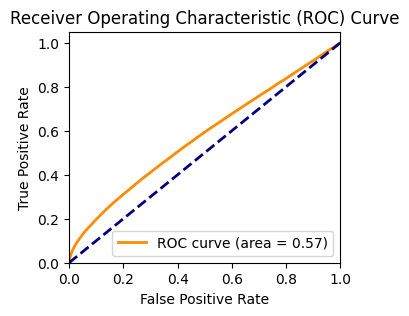

0

In [19]:
model_mlp.load_state_dict(torch.load('saved_ml_models/best_baseline_1_model.pth'))
plot_roc(model_mlp, test_dataloader)
compute_roc(model_mlp, test_dataloader, filename="baseline_1")